In [51]:
# Pick convention: 
# We work on a rectangular cell of side lengths a, b, c
# This cuboid is in the positive coordinates and centered at 0
# I.e. spanned by (a,0,0), (0,b,0) and (0,0,c)

# Loading Packages

In [1]:
import numpy as np
import numpy.linalg as la
import sympy as sp
import random as rd
import gudhi as gd
import Simplex_Classes_3D as sc
import pph_examples as ex
from Reduce2IntegerBasis import reduce_spanning_set_3d as rss3
from copy import deepcopy
import matplotlib.pyplot as plt

# String formatting

In [2]:
bold0 = "\033[1m" # begin bold
bold1 = "\033[0m" # end bold

# Generating random points (optional)

This function generates $N$ random points in a cell of sidelenghts $a,b,c$.  
This is for demonstration and testing, but not an integral part of the software.

In [3]:
def gen_points(N=5,a=1,b=1,c=1):
    """
    Generates N random points in [0,a]x[0,b]x[0,c] cuboid,
    outputts Nx3 numpy array, each row containing x, y,z coordinates of a point.
    """
    return np.array([[rd.random()*a,rd.random()*b,rd.random()*c] for i in range(N)])


# Creating periodic $\alpha$-filtration

## Auxiliary functions for periodic_filtration()

### Duplicating points to neighbouring cells
Given points in a unit cell, this function duplicates them by translating to all neighbouring cells.  
This is an auxiliary step to calculating the _periodic_ $\alpha$-filtration. 

In [4]:
def torus_copy(points, a=1,b=1,c=1):
    """
    Takes numpy array points of N points on axbxc cube
    and creates 8 copies surrounding it.
    
    Returns new_points, containing original points and 9+8+9=26 offset copies,
    so Nx27 points in total.
    """
    
    N = np.shape(points)[0]
    # first index  = which axbxc cuboid we are working on
    # second index = index of corresponding original point
    # third index  = x, y, z coordinates of point
    new_points = np.zeros((27,N,3)) 

    i = 0 # to index the cuboid
    for x in [-a,0,a]:
        for y in [-b,0,b]:
            for z in [-c,0,c]:
                transl = np.array([[x,y,z] for dummy in range(N)])
                new_points[i,:,:] = points + transl
                i += 1
            
    return new_points.reshape(-1,3)

### Other functions

In [5]:
    def setup_unit_complex(points,max_alpha_square=float("inf"),a=1,b=1,c=1):
        """
        Setup for periodic_fitration() where the gudhi package is used
        to create an alpha filtration on the duplicated points. 
        """
        points_3x3x3 = torus_copy(points,a,b,c)
        
        # alpha-complex gets generation by gudhi
        alpha_complex = gd.AlphaComplex(points_3x3x3)
        simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=max_alpha_square)
        filtration = simplex_tree.get_filtration()   
        coords_cuboid = [alpha_complex.get_point(i) for i in range(len(points_3x3x3))]
        
        # SWITCH: axbxc --> 1x1x1
        coords_unit = [[x/a, y/b, z/c] for [x,y,z] in coords_cuboid]
        
        return coords_unit, filtration

In [6]:

def dim_split(filt):
    """
    Takes list of simplices 'filt' with filtration values, 
    i.e. with elements ([3,2], 0.123)
    Splits filt by dimension of elements.
    Outputs the 4 seperate lists, one for each dimension 0 to 3.
    """
    simps_split = [[] for i in range(4)]
    
    for (simp, val) in filt:
        p = len(simp)-1
        simps_split[p].append((simp,val))
        
    return simps_split[0], simps_split[1], simps_split[2], simps_split[3]

In [7]:
def check_bound(point):
    """
    Takes point with x,y,z coordinates.
    Checks if point lies in cuboid [0,1) x [0,1) x [0,1).
    If yes, outputs True, else False.
    """
    x = point[0]
    y = point[1]
    z = point[2]
    
    return (    x >= 0 and x < 1 
            and y >= 0 and y < 1 
            and z >= 0 and z < 1)

In [8]:
def equiv_num(x1,x2):
    """
    Calculates 'x1-x2 mod 1', where we always want to take 
    the representative with the smallest absolute value. 
    """
    z1 = abs((x1 - x2)%1)
    z2 = abs(z1 - 1)
    return min(z1,z2)

In [9]:
def identification_list(S0_list, S0, coords, eps = 1e-5):
    """
    Input:
        S0_list ... naive filtration list  of 0-simplices ([3],3) as given by gudhi
        S0      ... list of Simplex0D objects generated from S0

    Output:
        identify_list ... list of lists with entries [i,j], 
                           meaning that the ith vertex has to be matched to the jth Simplex0D object
    """
    # build identification list for later reference when building higher simplices
    identify_list = []
    
    """
    !
    This loop below could be made much more efficient!
    """

    for i in range(len(S0_list)):
        simp, filt_value = S0_list[i]
        coord = np.array(coords[i])

        for Simplex in S0: # looking for the point in the unit cell this corresponds to              
            other_coord = Simplex.coords

            if ((equiv_num(coord[0],other_coord[0])<eps) and 
                (equiv_num(coord[1],other_coord[1])<eps) and
                (equiv_num(coord[2],other_coord[2])<eps)):

                identify_index = Simplex.index_total

        identify_list.append([i, identify_index])
    return identify_list


In [10]:
def order_vertex(indices, coords):
    """
    Takes two vertices and outputs them by lexicographical order.
    
    Input:
        indices ... list [n0, n1], where ni is the integer filtration index of the ith vertex, identifying it uniquely 
        coords  ... list of lists [[x0, y0, z0], [x1, y1, z1]] containing the coordinates of both points.
        
    Output:
        [nl, nr]   ... list of indices in lexicographical order
        [xl,yl,zl] ... coordinates of left vertex
        [xr,yr,zl] ... coordinates of right vertex 
    
    """
    
    [n0, n1] = indices
    [x0, y0, z0] = np.around(coords[0],5)
    [x1, y1, z1] = np.around(coords[1],5)
    # we round to avoid ordering errors due to "same" being not the same
    
    
    if x0 < x1 or (x0 == x1 and y0 < y1) or (x0 == x1 and y0 == y1 and z0 < z1):
        # 0 is left
        left  = 0
        right = 1

    else:
        # 1 is left
        left  = 1
        right = 0
    
    # left vertex
    nl = indices[left]
    xl = coords[left][0]
    yl = coords[left][1]
    zl = coords[left][2]

    # right vertex
    nr = indices[right]
    xr = coords[right][0]
    yr = coords[right][1]
    zr = coords[right][2]
    return [nl, nr], [xl,yl,zl], [xr,yr,zr]

In [11]:
def crossing_vector(coord):
    """
    Takes coordinates coord=[x,y,z], which lie in unit_cube
    OR any of the 17 farther-right adjecent cells (up, up-right, right, low-right or low).
    
    Assumes that this coordinate corresponds to lexicographically second vertex of a 1-simplex and
    calculates respective crossing vector of 1-simplex. 
    """
   
    
    x = coord[0]
    y = coord[1]
    z = coord[2]
    
    dtype = np.int64
    vector = np.zeros(3,dtype=dtype)
    
    if x >= 1:
        vector += np.array([1,0,0],dtype=dtype)
    if y < 0 or y >= 1:
        vector += np.array([0,1,0],dtype=dtype) * int(np.sign(y))
    if z < 0 or z >= 1:
        vector += np.array([0,0,1],dtype=dtype) * int(np.sign(z))
    
    return np.array(vector)

### Creation of Simplex objects

In [12]:
def create_S0(S0_list, coords):
    """
    Input:
        S0_list ... List of 0-simplices as generated by gudhi, 
        after having split them by dimension
    Output: 
        S0 ... List of Simplex0D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value 
        and the geometric coordinate of the point
    """

    int_filt_value = 0
    S0 = []

    for i in range(len(S0_list)):
        simp, filt_value = S0_list[i]

        # check if 0-simplex lies in main cell
        coord = coords[i]
        if check_bound(coord): # point lies inside main cell
            S0.append(sc.Simplex0D([int_filt_value], 
                                            int_filt_value, 
                                            filt_value, 
                                            coord))
            int_filt_value +=1
    return S0

In [13]:
def create_S1(S1_list, S0, coords, identify_list):
    """
    Input: 
        Input:
        S1_list ... List of 1-simplices as generated by gudhi, 
        after having split them by dimension
        S0 ...List of Simplex0D objects of the filtration
        coords ... list of coordinates of vertices ordered by integer filtration value
        identify_list ... identification list for periodically copied points as given by identification_list()
        
    Output: 
        S1 ... List of Simplex1D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value,
        the crossing vector as numpy array and the vertices constituting the boundary
        in lexicographical order
    """


    # note that this is not the actual integer filtration value 
    # and this will get corrected later on
    int_filt_value = len(S0) 
    S1 = []


    for i in range(len(S1_list)):
        simp, filt_value = S1_list[i]

        # check what the leftmost vertex is
        [nl, nr], coordl, coordr = order_vertex(simp, [coords[simp[0]], coords[simp[1]]])
        # Check if leftmost vertex is in unit cell
        if check_bound(coordl):
            

            # Calculate crossing vector
            cross_vec = crossing_vector(coordr)
            
            # identify the old vertices with the newly numerated ones!!!!! 
            # both for simplex, as well as for ordered vertices

            nl_new = (identify_list[nl])[1]
            nr_new = (identify_list[nr])[1]

            int_ordered_simp = sorted([nl_new,nr_new])
            lex_ordered_simp = [S0[nl_new], S0[nr_new]]
            
            S1.append(sc.Simplex1D(int_ordered_simp, 
                                   int_filt_value, 
                                   filt_value, 
                                   cross_vec,
                                   lex_ordered_simp
                                  ))

            int_filt_value +=1
    
    return S1


In [14]:
def find_2Simplex_boundary(points,coords,S1, eps):
    """
    Input:
        points ... integer filtration values of vertices
        coords ... coordinates (in unit cell and its duplicates) of vertices
        S1     ... list of Simplex1D objects
        
    Output:
        bound_1, bound_2, bound_3 ... three Simplex1D objects from S1 which are formed by these points
    """
    
    """
    ! ! ! 
    This has not yet been adapted to 3D (shift only consideres x and y)
    I just included the z coordinate into the old code so that everything runs. 
    Make sure this is done correctly!!
    ! ! !
    """
    
    
    p1,p2,p3 = points
    p1_coord,p2_coord,p3_coord = coords
    
    # first boundary element from p1 to p2
    verts_1  = sorted([p1,p2])
    cv_1 = crossing_vector(p2_coord)

    # second boundary element from p1 to p3
    verts_2  = sorted([p1,p3])
    cv_2 = crossing_vector(p3_coord)

    # third boundary element from p2 to p3
    verts_3  = sorted([p2,p3])
    cv_3 = crossing_vector(p3_coord-crossing_vector(p2_coord))
    
    
    
    for j in range(len(S1)):
        
        Simplex = S1[j]
        verts = Simplex.verts
        cv    = Simplex.cv

            
        if (verts[0] == verts_1[0]) and (verts[1] == verts_1[1]) and (np.linalg.norm(cv-cv_1)<eps):
            bound_1 = Simplex
        if (verts[0] == verts_2[0]) and (verts[1] == verts_2[1]) and (np.linalg.norm(cv-cv_2)<eps):
            bound_2 = Simplex
        if (verts[0] == verts_3[0]) and (verts[1] == verts_3[1]) and (np.linalg.norm(cv-cv_3)<eps):
            bound_3 = Simplex
            
    return [bound_1,bound_2,bound_3]

In [15]:
def create_S2(S2_list, S1, S0, coords, identify_list, eps):
    """
    Input: 
        Input:
        S2_list ... List of 2-simplices as generated by gudhi, 
        after having split them by dimension
        S1 ... List of Simplex1D objects of the filtration
        coords ... list of coordinates of vertices ordered by integer filtration value
        identify_list ... identification list for periodically copied points as given by identification_list()
        
    Output: 
        S2 ... List of Simplex2D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value,
        and the vertices constituting the boundary
        in lexicographical order
    """

    S2 = []
    int_filt_value = len(S0) + len(S1)
    for i in range(len(S2_list)):
        simp, filt_value = S2_list[i]

        # how can we find the correct 2-simplices?

        # if we have the vertices of the 2-simplex, we can look for 1-simplices which have two of these boundary points
        # since we only keep 2-simplices with their left-most point in the main cell
        # we can calculate the crossing vectors and then uniquly identify 2 out of 3 boundary elements

        # for the last edge, we have to 
        # - take the middle and the rightmost point,
        # - shift them such that the middle point is now in the main cell
        # - calculate the crossing vector of these shifted points
        # this is then the crossing vector of the last edge, and we can again identify
        # the correct 1-simplex using the vertices and the crossing vector


        # ordering vertices
        a0 = simp[0]
        b0 = simp[1]
        c0 = simp[2]
        a0_coord = coords[a0]
        b0_coord = coords[b0]
        c0_coord = coords[c0]

        [a1,b1], a1_coord, b1_coord = order_vertex([a0,b0], [a0_coord, b0_coord])
        [a2,c1], a2_coord, c1_coord = order_vertex([a1,c0], [a1_coord, c0_coord])
        [b2,c2], b2_coord, c2_coord = order_vertex([b1,c1], [b1_coord, c1_coord])

        # a2 is the leftmost, b2 is the middle and c2 is the rightmost coordinate, 
        # or a2 < b2 < c2 in lexicographical order


        # only if a2 is in the main cell do we continue
        if check_bound(a2_coord): 

            # the vertices are not yet in the naming convention we have chosen
            # so we rename them using identify_list
            for i in range(len(identify_list)):
                new_name = (identify_list[i])[1]
                if i == a2:
                    a2 = new_name
                if i == b2:
                    b2 = new_name
                if i == c2:
                    c2 = new_name


            bound_1,bound_2,bound_3 = find_2Simplex_boundary([a2,b2,c2],[a2_coord,b2_coord,c2_coord], S1, eps = eps)

            S2.append(sc.Simplex2D( sorted([a2,b2,c2]), int_filt_value, filt_value, [S0[a2],S0[b2],S0[c2]], [bound_1,bound_2,bound_3]))
            int_filt_value += 1
    return S2

In [16]:
def boundary4_from_rest(boundary1,boundary2,boundary3):
    """
    Given a 3-simplex, it has 4 boundary elements. 
    If we know 4 boundary 2-simplices, we can compare their respective edges.
    Collecting those that only show up for one 2-simplex each, 
    we can uniquly identify forth last 2-simplex by its boundary.
    """

    boundary4 = []
    # they each have one edge (1-simplex) which was not in the original list we searched for
    for edge in boundary1:
        if (edge not in boundary2) and (edge not in boundary3):
            boundary4.append(edge)

    for edge in boundary2:
        if (edge not in boundary1) and (edge not in boundary3):
            boundary4.append(edge)

    for edge in boundary3:
        if (edge not in boundary1) and (edge not in boundary2):
            boundary4.append(edge)
    return boundary4

In [17]:
def order_4_vertices(simp, coords):
    """
    Input:
        simp   ... 3-simplex constituted of 4 vertices, for example simp=[1,2,3,4]
        coords ... coordinates of the 4 vertices in the same order as in simp
    Ouptut:
        Integer filtration values and coordinates of the 4 points in 
        lexicographical order as dictated by their coordinates.
    """
    [n1, n2, n3, n4] = simp
    coord1 = coords[n1]
    coord2 = coords[n2]
    coord3 = coords[n3]
    coord4 = coords[n4]

    # ordering vertices
    a0 = n1
    b0 = n2
    c0 = n3
    d0 = n4
    a0_coord = coord1
    b0_coord = coord2
    c0_coord = coord3
    d0_coord = coord4

    [a1,b1], a1_coord, b1_coord = order_vertex([a0,b0], [a0_coord, b0_coord])
    [a2,c1], a2_coord, c1_coord = order_vertex([a1,c0], [a1_coord, c0_coord])
    [a3,d1], a3_coord, d1_coord = order_vertex([a2,d0], [a2_coord, d0_coord])
    # a3 is minimum
    [b2,c2], b2_coord, c2_coord = order_vertex([b1,c1], [b1_coord, c1_coord])
    [b3,d2], b3_coord, d2_coord = order_vertex([b2,d1], [b2_coord, d1_coord])
    # b3 is second smallest
    [c3,d3], c3_coord, d3_coord = order_vertex([c2,d2], [c2_coord, d2_coord])

    return a3,b3,c3,d3,a3_coord,b3_coord,c3_coord,d3_coord

In [18]:
def create_S3(S3_list, S2, S1, S0, coords, identify_list, eps):
    """
    Input: 
        Input:
        S3_list ... List of 3-simplices as generated by gudhi, 
        after having split them by dimension
        S2 ... List of Simplex1D objects of the filtration
        coords ... list of coordinates of vertices ordered by integer filtration value
        identify_list ... identification list for periodically copied points as given by identification_list()
        
    Output: 
        S3 ... List of Simplex3D objects containing the combinatorical representation,
        the integer filtration value, the continuous filtration value,
        and the edges constituting the boundary,
        and all vertices in lexicographical order
    """
    
    """
    !
    This code is just copied from S2.
    The code for S3 is not yet written (optional, since we don't need 3 simplices in my thesis) ...
    """
    
    
    S3 = []
    int_filt_value = len(S0) + len(S1) + len(S2)
    for i in range(len(S3_list)):
        simp, filt_value = S3_list[i] 
        
        a,b,c,d,a_coord,b_coord,c_coord,d_coord = order_4_vertices(simp, coords)
        
        # only if a3 is in the main cell do we continue
        if check_bound(a_coord): 
            
            # the vertices are not yet in the naming convention we have chosen
            # so we rename them using identify_list
           
            a = identify_list[a][1]
            b = identify_list[b][1]
            c = identify_list[c][1]
            d = identify_list[d][1]
            
            

            # we calculate 3 of the 6 1-simplices making up the 1-dim faces of our simplex
            boundary1 = find_2Simplex_boundary([a,b,c],[a_coord,b_coord,c_coord],S1, eps = eps)
            boundary2 = find_2Simplex_boundary([a,b,d],[a_coord,b_coord,d_coord],S1, eps = eps)
            boundary3 = find_2Simplex_boundary([a,c,d],[a_coord,c_coord,d_coord],S1, eps = eps)
            boundary4 = boundary4_from_rest(boundary1,boundary2,boundary3)


            # these edges form the last face
            # we now search for this last face

            # then we search for the 3 2-simplices that can be idenfified using these faces
            for simp2 in S2:
                S_bound = simp2.boundary
                if boundary1 == S_bound:
                    face1 = simp2
                elif boundary2 == S_bound:
                    face2 = simp2
                elif boundary3 == S_bound:
                    face3 = simp2
                elif boundary4 == S_bound:
                    face4 = simp2 
                    """
                    !
                    In this particular case, since boundary 4 is not outputted using the function we are used to
                    it might be that the == does not detect the permutation we have. 
                    !
                    """

            S3.append(sc.Simplex3D(sorted([a,b,c,d]), 
                                   int_filt_value, 
                                   filt_value, 
                                   [S0[a],S0[b],S0[c],S0[d]], 
                                   [face1,face2,face3,face4]
                                  )
                     )
            int_filt_value += 1
            del face1,face2,face3,face4
    return S3

### Functions for generating the (correct) torus filtration

In [19]:
def generate_pfilt(S0,S1,S2,S3):
    """
    Takes the lists of simplex objects Si and generates the 
    mixed-dimension periodic filtration, so with all the simplices, but only saved
    through their vertices and their continuous filtration value.
    """
    
    """
    ! 
    This needs to be optimised / made prettier
    !
    """

    periodic_filt = []
    
    for simplices in [S0, S1, S2, S3]:
        periodic_filt += [(simplex.verts, simplex.index_cont) for simplex in simplices]

    periodic_filt.sort(key = lambda some_tuple: some_tuple[1])

    return periodic_filt
    

In [20]:
def reorder_by_cont(S0,S1,S2,S3,periodic_filt):
    """
    Since the integer filtration value is wrong (first storted by dimension, 
    only then by actuall filtration value), this needs to be reordered.
    This function takes the Simplex, looks where it is in the periodic filtration,
    and reassignes this placement. 
    """
    # if there are some simplices, which combinatorially are equal and which are born at the same time,
    # we need to pick an arbitrary order
    # so we replace in dummy_filt already picked elements with None
    dummy_filt = periodic_filt.copy()
    
    for simplices in [S0,S1,S2,S3]:
        update_index(simplices, dummy_filt)
    
def update_index(simplices, periodic_filt):
    for simplex in simplices:
        int_filt = periodic_filt.index((simplex.verts, simplex.index_cont))
        periodic_filt[int_filt] = None
        
        simplex.update_index_total(int_filt)

In [21]:
# I don't think it makes sense to have calc_cc be a method, because it needs the very specific, fixed input S
# Instead I'm conna make it a function, which takes in S and then initialises the cc for all vertices. 


def old_calc_cc(simplex_objects):
    """
    Input:
        simplex_objects ... list of lists [S0,S1,S2,S3,S4] of all Simplex objects in periodic filtration
        
    No output. Changes the connected component attribute of all Simplex0D objects in S. 
    Hence if v is in S0, then v.component gets updated to the correct list of connected components at each time step.
    """
    
    N = sum([len(simplex_objects[i]) for i in range(4)]) # length of whole filtration
    N0 = len(simplex_objects[0])
    
    # initialise cc lists for all vertices
    cc_list = [[None for t in range(vert)] + [vert for t in range(N0-vert)] 
               for vert in range(N0)]
    
    # calculate full cc_list
    for edge in simplex_objects[1]:
        t0 = edge.vert0.index_total
        t1 = edge.vert1.index_total
        
        t  = edge.index_total
        
        # fill the cc list up to this timestep t up with the most recent cc
        cc_list[t0] += [cc_list[t0][-1] for i in range(t-len(cc_list[t0])+1)]
        cc_list[t1] += [cc_list[t1][-1] for i in range(t-len(cc_list[t1])+1)]
        
        # look at the cc of each point
        # and pick the earlier one
        new_cc = min(cc_list[t0][-1], cc_list[t1][-1])
        
        # update the cc of time t 
        cc_list[t0][-1] = new_cc
        cc_list[t1][-1] = new_cc
        
    # complete cc lists of all vertices with the one of their most recent cc
    cc_list[0] += [0 for i in range(N-len(cc_list[0]))]
    simplex_objects[0][0].create_cc(cc_list[0])
    print()
    print()
    print(cc_list[0])
    print()
    for n in range(1,N0):
        death_time = len(cc_list[n])
        last_cc = cc_list[n][deat_time-1]
        cc_list[n] += cc_list[last_cc][death_time:]
        print(cc_list[n])
        print()
        simplex_objects[0][n].create_cc(cc_list[n]) # assign cc lists to vertices
 

In [22]:
def calc_cc(simplex_objects):
    """
    Input:
        simplex_objects ... list of lists [S0,S1,S2,S3,S4] of all Simplex objects in periodic filtration
        
    No output. Changes the connected component attribute of all Simplex0D objects in S. 
    Hence if v is in S0, then v.component gets updated to the correct list of connected components at each time step.
    """
    N = sum([len(simplex_objects[i]) for i in range(4)]) # length of whole filtration
    N0 = len(simplex_objects[0])
    
    component_evolution = np.zeros((N0,N), dtype = np.int64)

    # from t=0 to t=N0-1 the vertices get born
    vertex_creation = [[-1 for t in range(vert)] + [vert for t in range(N0-vert)] for vert in range(N0)]
    # the -1 component is instead of None, because we are using a numpy array this time
    component_evolution[:,:N0] = vertex_creation
    
    last_t = N0-1
    for edge in simplex_objects[1]:
        t = edge.index_total
        v0_comp  = component_evolution[edge.vert0.index_total, last_t]
        v1_comp  = component_evolution[edge.vert1.index_total, last_t]
        dead_comp = max(v0_comp, v1_comp)
        life_comp = min(v0_comp, v1_comp)
        
        # fill up evolution up to and including t with most recent information
        for s in range(last_t+1,t+1):
            component_evolution[:,s] = component_evolution[:,s-1]
        
        if dead_comp != life_comp: # merger has happened
            for comp in range(N0):
                if component_evolution[comp, t] == dead_comp:
                    component_evolution[comp, t] = life_comp
                else:
                    component_evolution[comp, t] = component_evolution[comp, t-1]
        last_t = t
        
    for s in range(last_t+1,N):
        component_evolution[:,s] = component_evolution[:,s-1]
        
    for n in range(0,N0):
        comp_list = [None if x == -1 else x for x in component_evolution[n,:]]
        #print("component",n)
        #print(comp_list)
        #print()
        simplex_objects[0][n].create_cc(comp_list) # assign cc lists to vertices

## The final periodic_filtration()

In [23]:
import time

    
def periodic_filtration(points, max_alpha_square=float("inf"), a=1, b=1, c=1):

    """
    Input:
        a, b, c            ... side lengths of cell [0,a] x [0,b] x [0,c]
        points             ... numpy array of size (N,3) containing N points in cell
        max_alpha_square   ... maximum alpha (squared) value of alpha-filtration
        
    Output:
        periodic_filt ... list of filtration elements of the form ([1,2,38],index_cont)
        S             ... list of lists [S0,S1,S2,S3], each sub-list containing all Simplex objects of given dimension
    """
   
    eps = 1e-5 # for identification purposes (rounding errors)
    
    tic = time.perf_counter()
    coords_unit, filtration = setup_unit_complex(points, max_alpha_square, a, b, c)
    toc = time.perf_counter()
    print(f"Time of setup_unit_complex(): {toc - tic:0.4f}")

    # split unidentified simplices by dimension
    simp0, simp1, simp2, simp3 = dim_split(filtration)
    
    
    
    tic = time.perf_counter()
    # 0-Simplices ---------------------------------
    S0 = create_S0(simp0, coords=coords_unit)
    identify_list = identification_list(S0_list=simp0, S0=S0, coords=coords_unit, eps = eps)
    toc = time.perf_counter()
    print(f"Time of create_S0 and identification_list: {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # 1-Simplices ---------------------------------
    S1 = create_S1(S1_list=simp1, S0=S0, coords=coords_unit, identify_list=identify_list)  
    toc = time.perf_counter()
    print(f"Time of create_S1: {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # 2-Simplices ---------------------------------
    S2 = create_S2(S2_list=simp2, S1=S1, S0=S0, coords=coords_unit, identify_list=identify_list, eps = eps)
    toc = time.perf_counter()
    print(f"Time of create_S2(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # 3-Simplices
    S3 = create_S3(S3_list=simp3, S2=S2, S1=S1, S0=S0, coords=coords_unit, identify_list=identify_list, eps=eps) 
    toc = time.perf_counter()
    print(f"Time of create_S3(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    """
    !!!
    We need a comment about what this step does
    """
    periodic_filt = generate_pfilt(S0=S0,S1=S1,S2=S2,S3=S3)
    toc = time.perf_counter()
    print(f"Time of generate_pfilt(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # re-assign correct integer filtration value
    reorder_by_cont(S0=S0,S1=S1,S2=S2,S3=S3, periodic_filt=periodic_filt)
    toc = time.perf_counter()
    print(f"Time of reorder_by_cont(): {toc - tic:0.4f}")
    
    
    tic = time.perf_counter()
    # rescaling to axbxc cuboid
    for simp in S0:
        simp.transf_coord(a,b,c)
    toc = time.perf_counter()
    print(f"Time of coord backtrafo loop: {toc - tic:0.4f}")
    
    
    simplex_objects = [S0, S1, S2, S3]
    
    
    tic = time.perf_counter()
    # Calculate connected components of 0 simplices
    calc_cc(simplex_objects)
    toc = time.perf_counter()
    print(f"Time of calc_cc(): {toc - tic:0.4f}")
    
    
    

    
    return periodic_filt, simplex_objects
    


## TEST: periodic_filtration()

In [24]:
from importlib import reload  
sc = reload(sc)
N = 8
a,b,c = 1,1,1
points = gen_points(N,a,b,c)
p_filt, simplex_objects = periodic_filtration(points,a=a,b=b,c=c)


Time of setup_unit_complex(): 0.1008
Time of create_S0 and identification_list: 0.0030
Time of create_S1: 0.0328
Time of create_S2(): 0.1757
Time of create_S3(): 0.1770
Time of generate_pfilt(): 0.0001
Time of reorder_by_cont(): 0.0006
Time of coord backtrafo loop: 0.0000
Time of calc_cc(): 0.0015


# Calculating torus PH

After the calculation of the periodic filtration, next comes calculating the periodic persistent homology. The algorithm here should not differ significantly from the standard ones. The only reason we are writing this from scratch is that pre-existing software is not made to handle our data, especialy in case of degenerate simplices. 

## Auxiliary functions for PH()

In [25]:
def boundary_matrix(simplex_objects):
    """
    Takes list of subslists of Simplix type objects.
    Outputs a boundary matrix as numpy matrix.
    
    Note that the boundary matrix is sorted by dimension (their index in S[i]), not as given by .index_total
    """
    S0, S1, S2, S3 = simplex_objects
    
    # Initialise matrix of dimension s0+s1+s2(boundaries) x s1+s2+s3
    D = np.zeros((len(S0+S1+S2),len(S0+S1+S2+S3)))
    
    # The 0-Simplices all appear at the beginning and are already ordered by their usual index
 
    
    d = [len(simplex_objects[i]) for i in range(4)]
    
    for j in range(d[1]):
        for i in S1[j].verts:
            D[i,j+d[0]] += 1
    
    for j in range(d[2]):
        for i in range(d[1]):
            if S1[i] in S2[j].boundary:
                D[i+d[0],j+d[0]+d[1]] += 1
                
    for j in range(d[3]):
        for i in range(d[2]):
            if S2[i] in S3[j].boundary:
                D[i+d[0]+d[1],j+d[0]+d[1]+d[2]] += 1
    
   
    
    return np.mod(D,2)

In [26]:
def check_low(column):
    """ 
    Takes a column i.e. numpy 1dim array. 
    Outputs the index of the lowest non-zero element of the given column.
    If the column is all zero, it returns -1.
    """
    low = -1
    m = len(column)
    for i in range(0,m):
        if column[m-1-i]==1:
            low = m-1-i
            break
    return low


In [27]:
def column_reduction(D, exhaustive=False): 
    """
    Takes a binary boundary matrix and performs column reduction on it.
    Returns the reduced matrix "R", as well as a list of its pivot elements "pivots". 
    Zero columns are encoded in pivots as -1. 
    """
    
    
    """
    !!!!
    We want to implement exhaustive reduction at some point. 
    """
    # D is numpy array of size mxn
    (m,n) =  D.shape # rows, column
    R = D.copy()
    V = np.identity(n)
    
    pivots = []
    
    for i in range(0,n):
        # look at current pivot 
        low = check_low(R[:,i])
        
        # check if this is already a pivot element
        while (low in pivots) and (low != -1): 
            # while pivot is taken, perform matrix reduction on R
            
            j = pivots.index(low)
            R[:,i]= (R[:,i] + R[:,j]) % 2
            V[:,i]= (V[:,i] + V[:,j]) % 2
            
            # get new pivot
            low = check_low(R[:,i]) 
            
        pivots.append(low)
        
    
    return pivots, R, V



In [28]:
class TopologicalGroups:
    def __init__(self, dim=3):
        self.C = np.zeros(dim+1)
        self.Z = np.zeros(dim+1)
        self.B = np.zeros(dim+1)
        self.H = np.zeros(dim+1)
        self.dim = dim
        
    def calculate_group_dimensions(self, dim_list, pivots):
        m = 0
        for i in range(0,self.dim+1):
            # extract dimensions of vector spaces
            self.C[i]   = dim_list[i]
            self.Z[i]   = pivots[m:m+dim_list[i]].count(-1)
            self.B[i-1] = self.C[i] - self.Z[i]
            m += dim_list[i]

        for i in range(0,self.dim+1):
            self.H[i]   = self.Z[i] - self.B[i]

    

In [29]:
def calculate_int_persistence_pairs(D, pivots, simplex_objects_flat):
    r"""
    Calculates persistence pairs with integer timestep values.
    Formatted such that it can be plotted by gudhi: (dim, (a,b))
    """
    
    integer_pairs = IntegerPersistenceIntervals()
    integer_pairs.calculate_integer_intervals(D, pivots, simplex_objects_flat)
    
    return integer_pairs




class IntegerPersistenceIntervals:
    def __init__(self):
        self.list = []
        
    def calculate_integer_intervals(self, D, pivots, simplex_objects_flat):
        # calculate persistence pairs
        for j in range(D.shape[1]): # looking at the jth column
            # determine dimension of new simplex associated to jth row
            dim = simplex_objects_flat[j].dim

            # if jth column = 0 --> new cycle
            if pivots[j] == -1:
                self.append_infinite_pair(dim, simplex_objects_flat[j])
                
            # if jth column != 0 --> death of homology class (that must have been born previously)
            else:
                self.replace_infinite_pair(dim, simplex_objects_flat[pivots[j]], simplex_objects_flat[j])
        
        # sort by beginning of interval
        self.list.sort(key=lambda l: (l[1])[0])


    def append_infinite_pair(self, dim, simplex):
        a = simplex.index_total
        self.list.append((dim, (a,float("inf"))))

    def replace_infinite_pair(self, dim, birth_simplex, death_simplex):
        a = birth_simplex.index_total
        b = death_simplex.index_total
        
        try:
            self.list.remove((dim-1, (a, float("inf"))))
        except ValueError:
            print(f'Pair {(dim-1, (a, float("inf")))} has not yet been added to pp_list and hence cannot be removed.')
        else:
            self.list.append((dim-1, (a,b)))


In [30]:
def create_persistence_pairs_list(integer_pairs, torus_filtration, V, simplex_objects):
    persistence_pairs = []
    
    for (dim,(a,b)) in integer_pairs.list:
        pair = sc.Persistence_Pair(dim, (a,b))
        pair.int2cont_interval(torus_filtration)
        if dim == 0 or dim == 1:
            pair.calc_birth_rep(V, simplex_objects)
            pair.calc_cc()
        persistence_pairs.append(pair)
    
    del pair
    
    """
    ! ! !
    The Code below was created because at every time step, either a new pair is 
    created or dies. This was not the case, so I had to investigate the timsteps.
    I will leave this in for now, but it should be removed.
    """
    dummy_list_1 = [pair.lifespan_int[0] for pair in persistence_pairs]
    dummy_list_2 = [pair.lifespan_int[1] for pair in persistence_pairs]
    dummy_list = dummy_list_1 + dummy_list_2
    dummy_list.sort()
    
    boo = False
    for i in range(len(torus_filtration)):
        if i not in dummy_list:
            print("this number was skipped:")
            print(i)
            boo = True
    if boo == False:
        print("every number was covered")
        
    """
    Here this ends ...
    """
        
    persistence_pairs.sort(key=lambda pair: pair.lifespan_int[0])
    return persistence_pairs
  

In [31]:
def generate_persistence_pairs(D, V, pivots, torus_filtration, simplex_objects):
    simplex_objects_flat =  [simp for sublist in simplex_objects for simp in sublist]
    
    integer_pairs = calculate_int_persistence_pairs(D, pivots, simplex_objects_flat)
    persistence_pairs  = create_persistence_pairs_list(integer_pairs, torus_filtration, V, simplex_objects)
  
    return persistence_pairs

## The final PH()

In [32]:
def PH(filt, simplex_objects):
    """
    Takes list "filt" of naive filtration with continuous filtration values and
    list "simplex_objects" containing sublists of Simplex type objects, sorted by dimension.
    
    Returns the dimensions of Cn, Bn, Zn and Hn, 
    as well as persistence pairs "pp" and representatives "reps" of homology classes.
    """
    
    
    d=3 # this is the dimension we are working in
    
    tic = time.perf_counter()
    D = boundary_matrix(simplex_objects)
    toc = time.perf_counter()
    print(f"Time of boundary_matrix(): {toc - tic:0.4f}")
    
    dim_list = [len(simplex_objects[i]) for i in range(0,d+1)]
    
    tic = time.perf_counter()
    pivots, R, V = column_reduction(D)
    toc = time.perf_counter()
    print(f"Time of column_reduction(): {toc - tic:0.4f}")
    
    tic = time.perf_counter()
    top_groups = TopologicalGroups()
    top_groups.calculate_group_dimensions(dim_list, pivots)
    toc = time.perf_counter()
    print(f"Time of calculating topological groups(): {toc - tic:0.4f}")
    
    tic = time.perf_counter()
    persistence_pairs = generate_persistence_pairs(D, V, pivots, filt, simplex_objects)
    toc = time.perf_counter()
    print(f"Time of generate_persistence_pairs(): {toc - tic:0.4f}")

    
    
    return top_groups, persistence_pairs

## Plotting torus persistent pairs

In [33]:
def plot_persistence_pairs(persistence_pairs):
    pair_list = [(pair.dim, pair.lifespan_cont) for pair in persistence_pairs]
    gd.plot_persistence_diagram(pair_list)

## TEST: PH()

In [34]:
from importlib import reload  
sc = reload(sc)
N = 10
a,b,c = 2,1,1
points = gen_points(N,a,b,c)
p_filt, simplex_objects = periodic_filtration(points,a=a,b=b,c=c)
#print()
top_groups, persistence_pairs = PH(p_filt, simplex_objects)
#print("\nBetti numbers")
#print(top_groups.H)
#plot_persistence_pairs(persistence_pairs)


Time of setup_unit_complex(): 0.1195
Time of create_S0 and identification_list: 0.0053
Time of create_S1: 0.0473
Time of create_S2(): 0.2270
Time of create_S3(): 0.2230
Time of generate_pfilt(): 0.0002
Time of reorder_by_cont(): 0.0009
Time of coord backtrafo loop: 0.0000
Time of calc_cc(): 0.0022
Time of boundary_matrix(): 0.0056
Time of column_reduction(): 0.0760
Time of calculating topological groups(): 0.0000
every number was covered
Time of generate_persistence_pairs(): 0.0085


In [35]:
persistence_pairs[3].component == simplex_objects[0][3].component

True

# Calculating the evolution of $\Lambda_0$

## Auxiliary functions for Lambda_0_evolution()

In [36]:
def vol_0d():
    return 1

def vol_1d(vector):
    return sp.Matrix(vector).norm()

def vol_2d(vector1, vector2):
    return sp.Matrix(vector1).cross(sp.Matrix(vector2)).norm()

def vol_3d(vector1, vector2, vector3):
    return sp.Matrix([vector1, vector2, vector3]).det()


def volume_pd(vector_matrix):
    r""" Takes list of p linearly independant vectors 
    and calculates the p-dimensional volume they span.
    
    """
    p = la.matrix_rank(vector_matrix)
    
    if p == 0:
        det_p = vol_0d()
    if p == 1:
        det_p = vol_1d(vector_matrix[:,0])
    if p == 2:
        det_p = vol_2d(vector_matrix[:,0], vector_matrix[:,1])
    if p == 3:
        det_p = vol_3d(vector_matrix[:,0], vector_matrix[:,1], vector_matrix[:,2])
    
    return abs(det_p), p

## Event Types (Objects)

In [37]:

# these are the final object types that are outputted

class Merger:
    def __init__(self, timestep, old_comp, new_comp, cv_list, dim, det_abs, det_rel):
        self.time = timestep
        self.old_component = old_comp
        self.new_component = new_comp
        self.dim = dim
        self.det_abs = det_abs
        self.det_rel = det_rel 
        self.crossing_vector_list = cv_list
    
    
class StaticSublattice:
    def __init__(self, time, component, cv_list, basis_matrix, dim, det_abs, det_rel):
        self.time = time
        self.component = component
        self.crossing_vector_list = cv_list
        self.basis_matrix = basis_matrix
        self.dim = dim
        self.det_abs = det_abs
        self.det_rel = det_rel    


## The final Lambda_0_evolution()

def Lambda_0_evolution(p_filt, N, persistence_pairs, trafo_matrix):
    """
    ! ! !
    DOCUMENTATION MISSING
    !!!
    """

    Lambda0_list = [SublatticeEvolution(comp, trafo_matrix) for comp in range(N)]
    
                        
    for t in range(len(p_filt)):
        time_slice = TimeSlice(t, p_filt, N)
        time_slice.pair_update(persistence_pairs)
        
        for comp in range(N):
            Lambda0_list[comp].update_timestep(t, time_slice.all_bases[comp], time_slice.merger)
        
    
    return [Lambda0_list[comp].evolution for comp in range(N)]


In [38]:
def Lambda_0_evolution(p_filt, N, persistence_pairs, trafo_matrix):
    """
    ! ! !
    DOCUMENTATION MISSING
    ! ! !
    """
    
    Lambda0_list = [[StaticSublattice(0, component, [], np.zeros((3,3),dtype=np.int32), 0, 1, 1/la.det(trafo_matrix))] for component in range(N)]
    
                        
    for t in range(len(p_filt)):
        # search for pair that acts at time t
        for pair in persistence_pairs:
            if check_birth(pair, t): # new 1-homology born
                vec = pair.calc_cv()
                if check_cv_nontrivial: 
                    comp = pair.component[t]
                    old_cvs = Lambda0_list[comp][-1].crossing_vector_list
                    cv_list = rss3(old_cvs, vec)
                    matrix = generate_basis_matrix(cv_list, trafo_matrix)
                    det_abs, dim = volume_pd(matrix)
                    det_rel = det_abs / la.det(trafo_matrix) 
                    
                    conditional_new_sublattice(Lambda0_list[comp], 
                                               t, 
                                               comp, 
                                               cv_list, 
                                               matrix,
                                               det_abs, 
                                               det_rel, 
                                               dim)
                    
            
            
            elif check_death(pair, t): # 0-homology (connected component) dies
                dead_comp = pair.component[t-1]
                surviving_comp = pair.component[t]
                dead_comp_cvs = Lambda0_list[dead_comp][-1].crossing_vector_list
                surviving_comp_cvs = Lambda0_list[surviving_comp][-1].crossing_vector_list
                cv_list = surviving_comp_cvs.copy()
                for vec in dead_comp_cvs:
                    cv_list = rss3(cv_list, vec)
                matrix = generate_basis_matrix(cv_list, trafo_matrix)
                det_abs, dim = volume_pd(matrix)
                det_rel = det_abs / la.det(trafo_matrix) 
                
                merger = Merger(t, dead_comp, surviving_comp, cv_list, dim, det_abs, det_rel)
                Lambda0_list[dead_comp].append(merger)
                Lambda0_list[surviving_comp].append(merger)
                conditional_new_sublattice(Lambda0_list[surviving_comp], 
                                           t, 
                                           surviving_comp, 
                                           cv_list, 
                                           matrix, 
                                           det_abs, 
                                           det_rel, 
                                           dim)
                
        
    return Lambda0_list



def check_birth(pair, t):
    """
    Returns True if persistence pair is born at time t, otherwise returns False. 
    """
    return ((pair.dim == 1) and 
            (pair.lifespan_int[0] == t)
           )

def check_death(pair, t):
    """
    Returns True if persistence pair is born at time t, otherwise returns False. 
    """
    return ((pair.dim == 0) and 
            (pair.lifespan_int[1] == t)
           )

def check_cv_nontrivial(vector):
    """
    Returns True if (integer) vector is non-zero.
    """
    return abs(la.norm(vector)) > 0.9

def generate_basis_matrix(crossing_vector_list, trafo_matrix):
    basis_matrix = np.zeros((3,3),dtype=np.int32)

    for i in range(len(crossing_vector_list)):
        basis_matrix[:,i] = crossing_vector_list[i]

    return np.dot(trafo_matrix, basis_matrix)

def check_sublattice_change(last_event, new_det_abs, new_dim):
    """
    ! ! !
    here we might get floating point errors when compaing the determinants
    make this more foolproof
    """
    return (last_event.det_abs != new_det_abs or 
            last_event.dim != new_dim
           )


def conditional_new_sublattice(past_comp_evolution, time, comp, cv_list, matrix, det_abs, det_rel, dim):
    if check_sublattice_change(past_comp_evolution[-1], det_abs, dim):
        past_comp_evolution.append(StaticSublattice(time, 
                                                    comp, 
                                                    cv_list, 
                                                    matrix, 
                                                    dim, 
                                                    det_abs, 
                                                    det_rel))


## TEST:  Lambda_0_evolution()

Time of setup_unit_complex(): 0.0684
Time of create_S0 and identification_list: 0.0016
Time of create_S1: 0.0235
Time of create_S2(): 0.1105
Time of create_S3(): 0.1086
Time of generate_pfilt(): 0.0002
Time of reorder_by_cont(): 0.0003
Time of coord backtrafo loop: 0.0000
Time of calc_cc(): 0.0008

Time of boundary_matrix(): 0.0022
Time of column_reduction(): 0.0228
Time of calculating topological groups(): 0.0000
every number was covered
Time of generate_persistence_pairs(): 0.0025

Betti numbers
[1. 3. 3. 1.]

Time of Lambda_0_evolution(): 0.1167


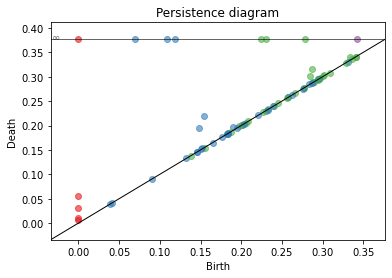

In [40]:
from importlib import reload  
sc = reload(sc)
N = 5
a,b,c = 1,1,1
points = gen_points(N,a,b,c)

p_filt, simplex_objects = periodic_filtration(points,a=a,b=b,c=c)
print()
top_groups, persistence_pairs = PH(p_filt, simplex_objects)
print("\nBetti numbers")
print(top_groups.H)
plot_persistence_pairs(persistence_pairs)
print()
    
tic = time.perf_counter()  
trafo_matrix = np.diag([a,b,c])
evol = Lambda_0_evolution(p_filt, N, persistence_pairs, trafo_matrix);
toc = time.perf_counter()
print(f"Time of Lambda_0_evolution(): {toc - tic:0.4f}")

# Creating Merge Tree

## Merge Tree code

In [73]:
class MergeOrder:
    def __init__(self, data):
        self.data_static = deepcopy(data)
        self.data = deepcopy(data)
        self.R = [] # list of ordered indices
        self.current_branch_index = 0
        self.current_branch = self.data[0]
        
    def set_branch(self, index):
        self.current_branch_index = index
        self.current_branch = self.data[self.current_branch_index]
        
    def generate_order(self):
        self.data = deepcopy(self.data_static)
        self.set_branch(0)
        
        self.iterator()
        return self.R
    
    def iterator(self):
        # current branch
        merger_list = self.current_branch[:-1]
        if len(merger_list) == 0:
            self.R.append(self.current_branch_index)
            #print("R:",self.R)
            
            if self.current_branch_index != 0:
                mother_index = self.current_branch[-1].new_component
                # reached end of branch, switch to next branch on mother branch {mother_index}
                self.data[mother_index].pop(-2)
                self.set_branch(mother_index)
                self.iterator()
        else:
            # go deeper
            new_branch_index = merger_list[-1].old_component
            self.set_branch(new_branch_index)
            self.iterator()









def plot_mergetree(data, width=5, height=7):
    fig, ax = plt.subplots()
    order = MergeOrder(data).generate_order()
    N = len(order)
    
    fig.set_size_inches(width, height)
    
    # create plot with vertical lines of correct lengths
    ax.set_ylabel("time steps (integer)") # for now everything in integer time steps
    ax.set_xlabel("component") 
    ax.set_yticks([0]+[data[component][-1].time for component in range(1,N)])
    ax.set_xticks([i for i in range(N)])
    ax.set_xticklabels([str(comp) for comp in order])
    
    [ax.spines[edge].set_visible(False) for edge in ['top', 'bottom', 'right', 'left']]
    for component in range(N):
        x1 = order.index(component)
        x2 = order.index(data[component][-1].new_component)
        age = data[component][-1].time
        ax.plot([x1, x1], [0, age], "black")
        ax.plot([x1, x2], [age, age], "black")

        
        
        
def extract_mergers_from_branch(branch):
    return [event for event in branch if type(event) == Merger]
 
def extract_mergers_global(data):
    mergers = [extract_mergers_from_branch(branch) for branch in data]
    last_event_time = mergers[0][-1].time
    mergers[0].append(Merger(last_event_time + 2, 0, 0, None, None, None, None))
    return mergers

## Testing plot_mergetree()

Time of merge tree plotting: 0.0404


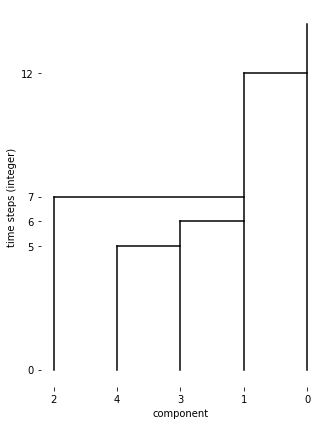

In [74]:
#from importlib import reload  
#sc = reload(sc)
#N = 5
#a,b,c = 1,1,1
#points = gen_points(N,a,b,c)
#
#p_filt, simplex_objects = periodic_filtration(points,a=a,b=b,c=c)
#print()
#top_groups, persistence_pairs = PH(p_filt, simplex_objects)
#print("\nBetti numbers")
#print(top_groups.H)
#plot_persistence_pairs(persistence_pairs)
#print()
#    
#tic = time.perf_counter()  
#trafo_matrix = np.diag([a,b,c])
#evol = Lambda_0_evolution(p_filt, N, persistence_pairs, trafo_matrix);
#toc = time.perf_counter()
#print(f"Time of Lambda_0_evolution(): {toc - tic:0.4f}")


tic = time.perf_counter()  
only_mergers = extract_mergers_global(evol)
#print(only_mergers)
#for comp in only_mergers:
#    print()
#    print(only_mergers.index(comp))
#    for merger in comp:
#        print(f"At t={merger.time}, {merger.old_component} --> {merger.new_component}")
plot_mergetree(only_mergers)
toc = time.perf_counter()
print(f"Time of merge tree plotting: {toc - tic:0.4f}")

# Examples

## Functions for Examples

In [65]:
class ExamplePrint:
    def __init__(self, points, a=1, b=1, c=1):
        self.points = points
        self.scale_x = a
        self.scale_y = b
        self.scale_z = c
        self.trafo_matrix = np.diag([a,b,c])
        self.N = len(points)
        
        self.groups = None
        self.pairs  = None
        self.evolution = None
        
    def calculate_pph(self):
        p_filt, simplex_objects = periodic_filtration(self.points,
                                                      a=self.scale_x,
                                                      b=self.scale_y,
                                                      c=self.scale_z)

        self.groups, self.pairs = PH(p_filt, simplex_objects)
        self.evolution = Lambda_0_evolution(p_filt, self.N, self.pairs, self.trafo_matrix);

        
    def describe_evolution(self):
        #plot_persistence_pairs(persistence_pairs)
        for comp in range(self.N):
            print("-------------------")
            print(f"{bold0}COMPONENT {comp}{bold1}")
            self.describe_component_evolution(comp)
            
            

    def describe_component_evolution(self, comp):
        for i in range(len(self.evolution[comp])):
            state = self.evolution[comp][i]
            if type(state) == StaticSublattice:
                print(f"""
{bold0}Timestep {state.time}{bold1}
dimension = {state.dim}
determinant = {float(state.det_abs):2.2f}
det. ratio  = {float(state.det_rel):2.2f}
basis = \n{state.basis_matrix}
                """)
                
            elif type(state) == Merger:
                print(f"""
{bold0}Timestep {state.time}{bold1}
Component {state.old_component} merged to component {state.new_component}.
""")
   

    def plot_evolution(self, width=5, height=7):
        only_mergers = extract_mergers_global(self.evolution)
        plot_mergetree(only_mergers, width, height)

# Run Examples

## Example: Random points in axbxc cell

Time of setup_unit_complex(): 0.1669
Time of create_S0 and identification_list: 0.0085
Time of create_S1: 0.0578
Time of create_S2(): 0.3062
Time of create_S3(): 0.3053
Time of generate_pfilt(): 0.0003
Time of reorder_by_cont(): 0.0015
Time of coord backtrafo loop: 0.0000
Time of calc_cc(): 0.0025
Time of boundary_matrix(): 0.0090
Time of column_reduction(): 0.1641
Time of calculating topological groups(): 0.0000
every number was covered
Time of generate_persistence_pairs(): 0.0153


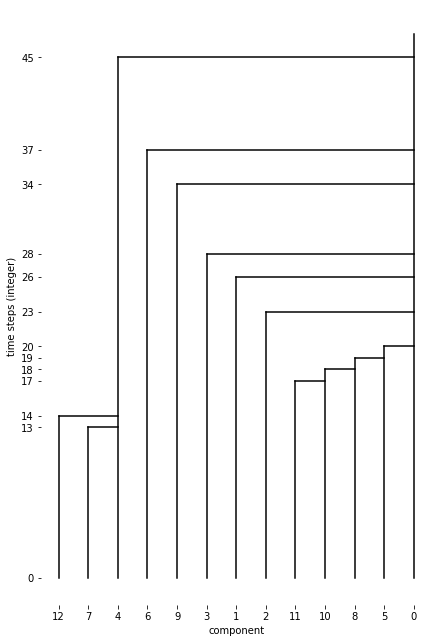

In [76]:
# random points example
N = 13
a,b,c = 1,1,1
#r_points = gen_points(N, a, b, c)
random_example = ExamplePrint(r_points, a=a, b=b, c=c)
random_example.calculate_pph()
#random_example.describe_evolution()
random_example.plot_evolution(width=7, height=11)

## Example: Torus knot (p,q)

Time of setup_unit_complex(): 1.9831
Time of create_S0 and identification_list: 0.0335
Time of create_S1: 0.1111
Time of create_S2(): 0.5850
Time of create_S3(): 0.5420
Time of generate_pfilt(): 0.0011
Time of reorder_by_cont(): 0.0053
Time of coord backtrafo loop: 0.0000
Time of calc_cc(): 0.0070
Time of boundary_matrix(): 0.0419
Time of column_reduction(): 0.7430
Time of calculating topological groups(): 0.0000
every number was covered
Time of generate_persistence_pairs(): 0.0583
-------------------
COMPONENT 0

Timestep 0
dimension = 0
determinant = 1.00
det. ratio  = 1.00
basis = 
[[0 0 0]
 [0 0 0]
 [0 0 0]]
                

Timestep 52
Component 14 merged to component 0.


Timestep 54
Component 10 merged to component 0.


Timestep 56
Component 2 merged to component 0.


Timestep 58
dimension = 1
determinant = 2.24
det. ratio  = 2.24
basis = 
[[1 0 0]
 [2 0 0]
 [0 0 0]]
                

Timestep 60
Component 1 merged to component 0.


Timestep 61
dimension = 2
determinant = 1.00


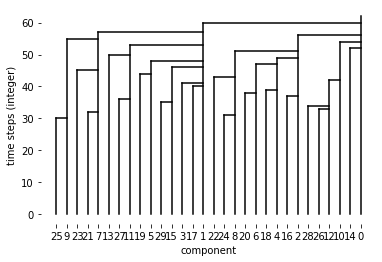

In [51]:
# torus knot example
p = 11
q = 2 # neq p
res = 30
t_points = ex.torus_knot(p=p, q=q, dim=3, res=res)
"""
! ! ! 
There is an error in the setting of p=15 and q=2 (res=30, I believe).
Check this out!!

! ! !
For  p=11, q=2, res=30, many components jump in dimension like this:
 0 -> 1 -> 0 -> 1
Should this be possible?
"""
torus_knot_example = ExamplePrint(t_points, a=1, b=1, c=1)
torus_knot_example.calculate_pph()
torus_knot_example.describe_evolution()
torus_knot_example.plot_evolution()

## Example: Teresa's interwoven grid (1)

Time of setup_unit_complex(): 1.7664
Time of create_S0 and identification_list: 0.1189
Time of create_S1: 0.3024
Time of create_S2(): 1.9195
Time of create_S3(): 1.8798
Time of generate_pfilt(): 0.0013
Time of reorder_by_cont(): 0.0352
Time of coord backtrafo loop: 0.0001
Time of calc_cc(): 0.0238
Time of boundary_matrix(): 0.2312
Time of column_reduction(): 9.0974
Time of calculating topological groups(): 0.0001
every number was covered
Time of generate_persistence_pairs(): 0.3198
-------------------
COMPONENT 0

Timestep 0
dimension = 0
determinant = 1.00
det. ratio  = 1.00
basis = 
[[0 0 0]
 [0 0 0]
 [0 0 0]]
                

Timestep 50
Component 30 merged to component 0.


Timestep 51
Component 40 merged to component 0.


Timestep 54
Component 1 merged to component 0.


Timestep 60
Component 2 merged to component 0.


Timestep 62
Component 5 merged to component 0.


Timestep 63
Component 7 merged to component 0.


Timestep 66
Component 31 merged to component 0.


Timestep 84
Comp

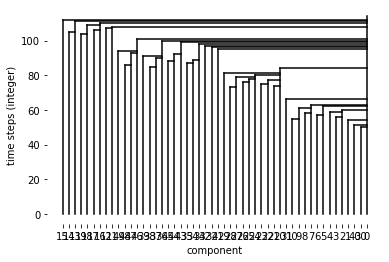

In [52]:
# Teresa's interwoven grid
from importlib import reload  
ex = reload(ex)
# number of points is 5x num_steps
g_points = ex.interwoven_grid(num_steps=10)

teresas_example = ExamplePrint(g_points, a=1, b=1, c=1)
teresas_example.calculate_pph()
teresas_example.describe_evolution()
teresas_example.plot_evolution()

# End